In [35]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from IPython.display import Image as IPImage, display
from dotenv import load_dotenv
import os
load_dotenv()

True

In [36]:
# Specify your paths and class names
IMAGE_CLASSIFY_MODEL_PATH = os.environ.get('IMAGE_CLASSIFY_MODEL_PATH')
IMAGE_CLASSES = sorted(os.environ.get('IMAGE_CLASSES').split(','))

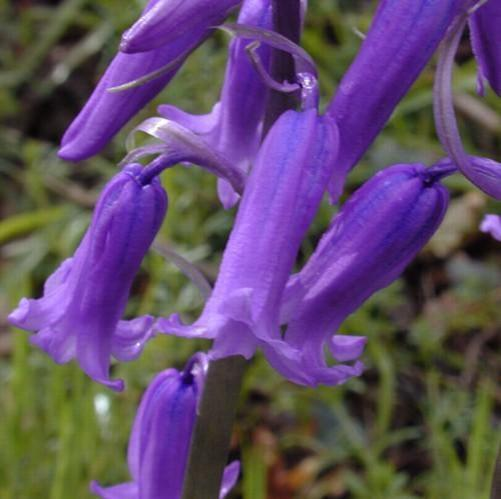

In [37]:
# Example usage
image_path = './data/jpg/image_0251.jpg'  # Replace with your image path
display(IPImage(filename=image_path))

In [38]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")

# Define the transform for inference
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Load the model
def load_model(model_path, num_classes):
    model = models.resnet18(weights=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_ftrs, num_classes)
    )
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()
    return model


# Load the model
model = load_model(f"../../{IMAGE_CLASSIFY_MODEL_PATH}", len(IMAGE_CLASSES))


# Function to classify a single image
def classify_image(image_path):
    # Open and transform the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

    # Get the index of the maximum probability
    max_index = torch.argmax(probabilities).item()

    # Return the class name and its probability
    return {
        'predicted_class': IMAGE_CLASSES[max_index],
        'probability': probabilities[max_index].item()
    }


classify_image(image_path)

{'predicted_class': 'Bluebell', 'probability': 0.9149460792541504}